In [1]:
import json
from typing import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import butter, filtfilt

### 1.0 Raw Emg Signals

Read raw emg signal with correction to signal in volts 

In [14]:
filename = "data/sitting/exp_1"
df = pd.read_csv(f"../{filename}.csv")
time, data = df["time"].to_numpy(), df[["emg1", "emg2", "emg3"]].to_numpy() * 3.3 / 65535
with open(f"../{filename}_points.json", "r") as f:
    points = json.load(f)

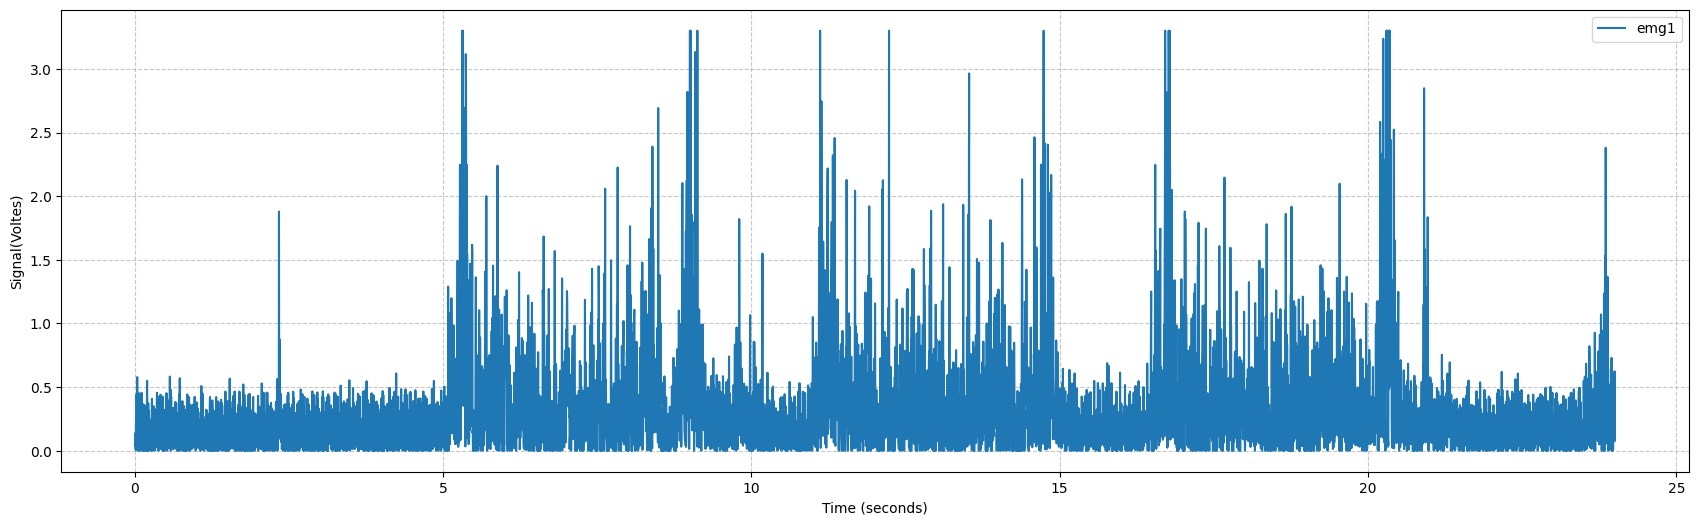

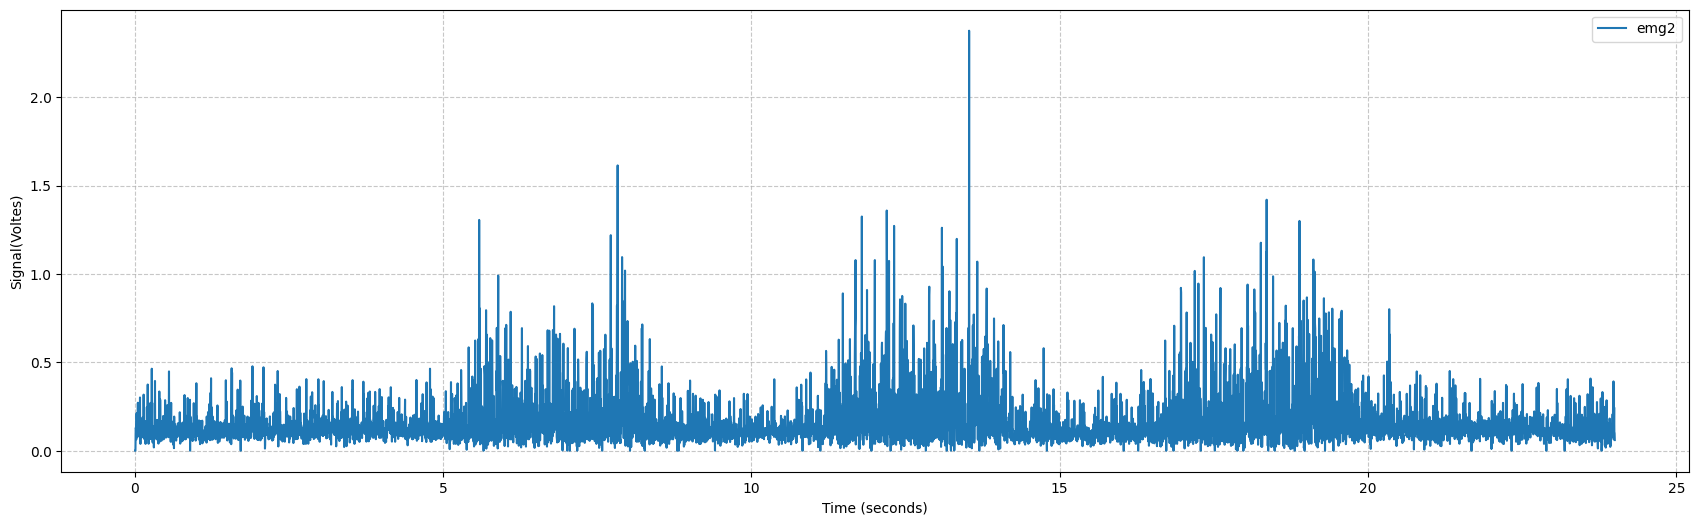

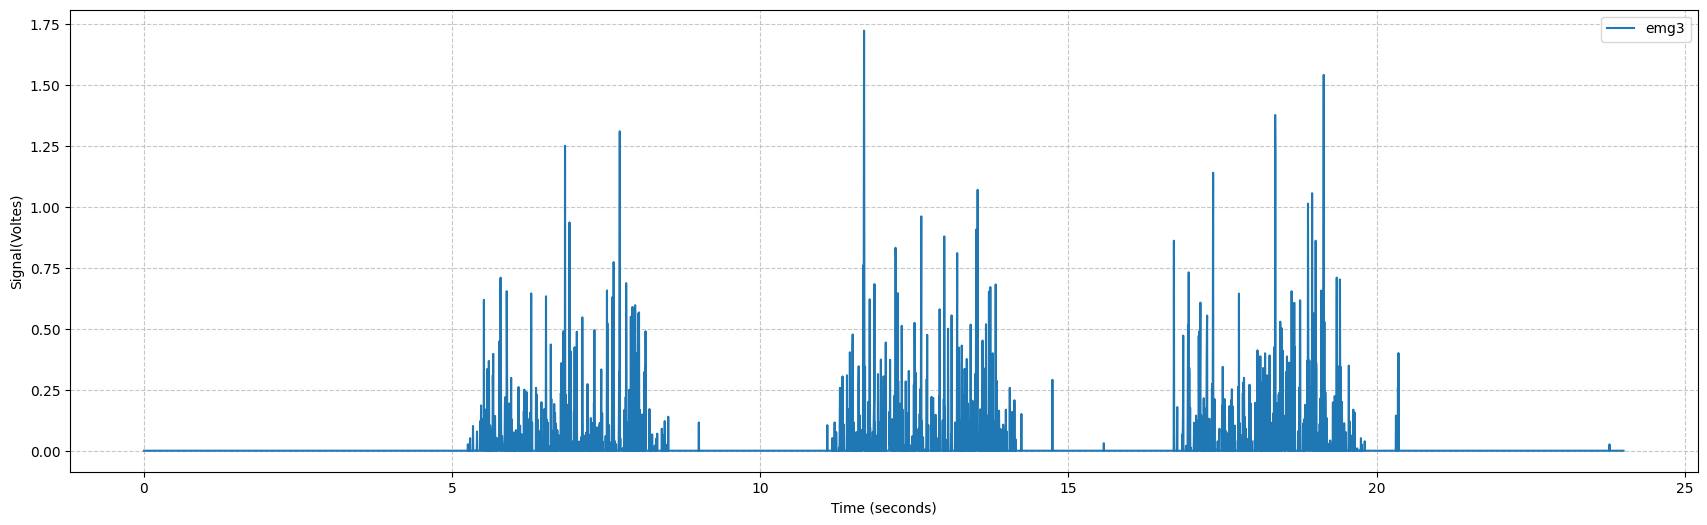

In [15]:
plt.figure(figsize=(21, 6))
plt.plot(time, data[:, 0], label="emg1")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data[:, 1], label="emg2")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data[:, 2], label="emg3")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

### 1.1 Remove mean EMG

Detect baseline, from test recording in file points. Get mean values from baseline and remove them from emg signal, and cut baseline data

In [4]:
baseline_idx = np.argwhere(time >= points["baseline"])[0][0]
baseline = data[:baseline_idx, :]
x0 = np.mean(baseline, axis=0)

normalize = data - x0
yf = np.argwhere(time >= 20)[0][0]

time = time[baseline_idx:yf]
data_removed_mean = normalize[baseline_idx:yf, :]

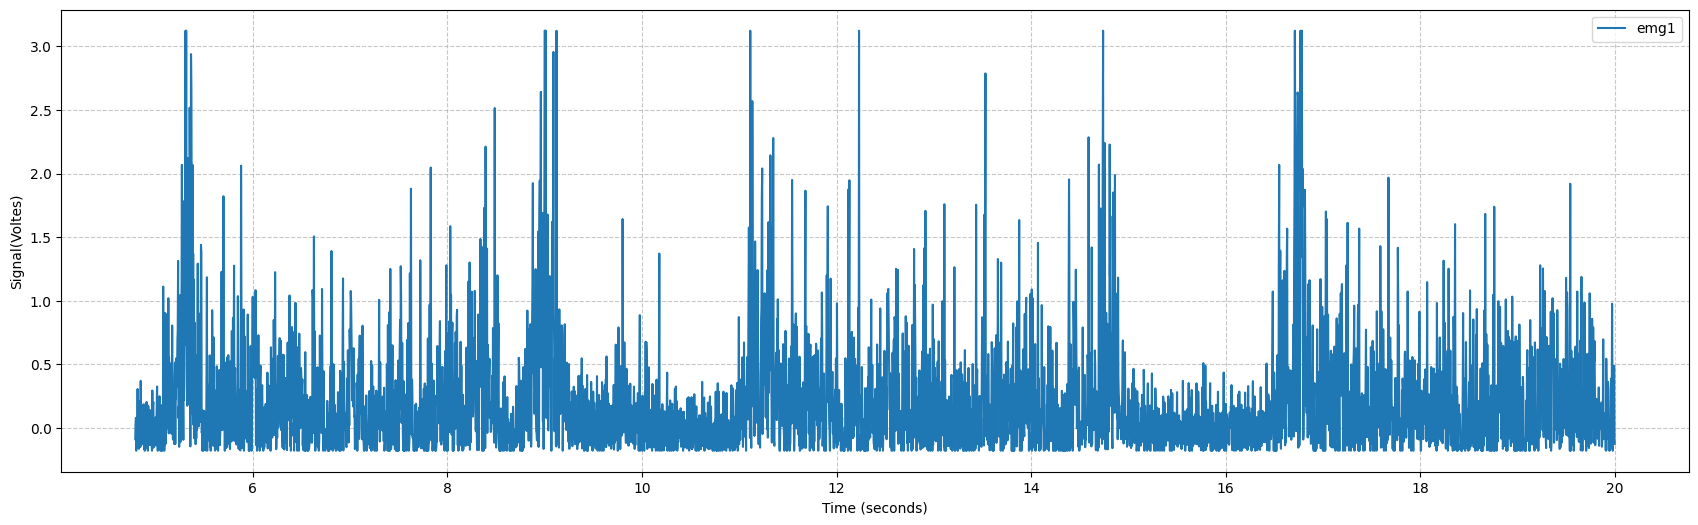

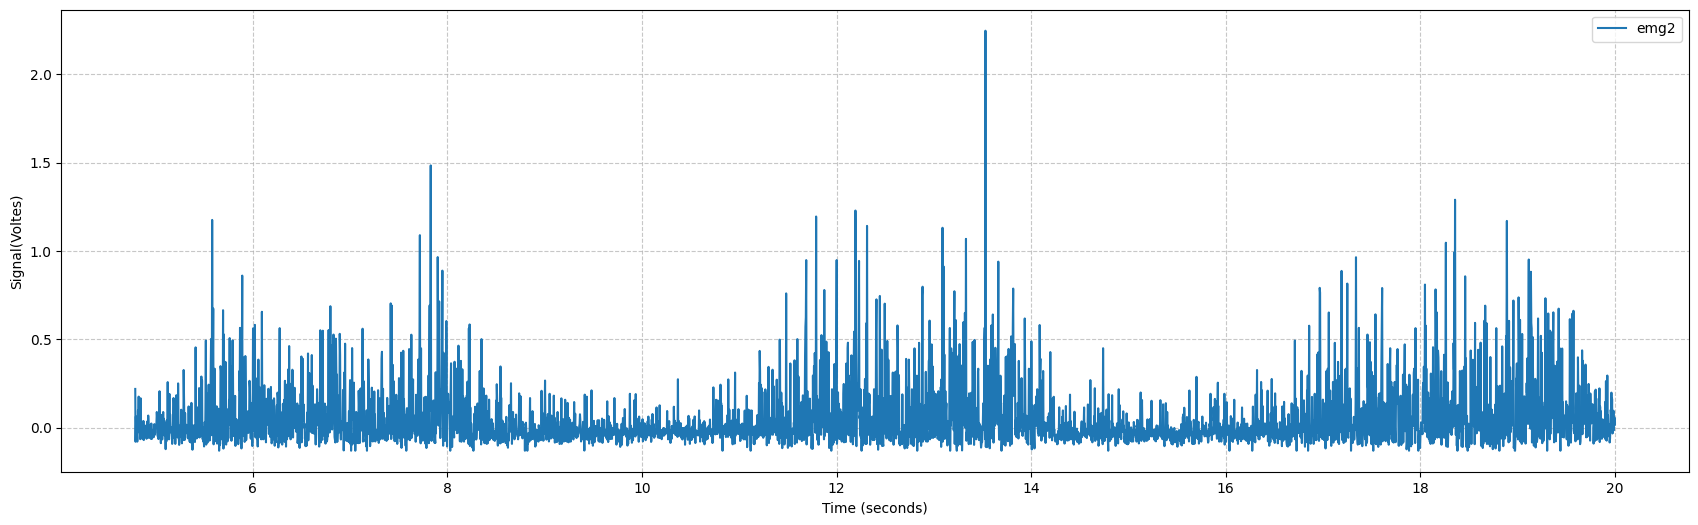

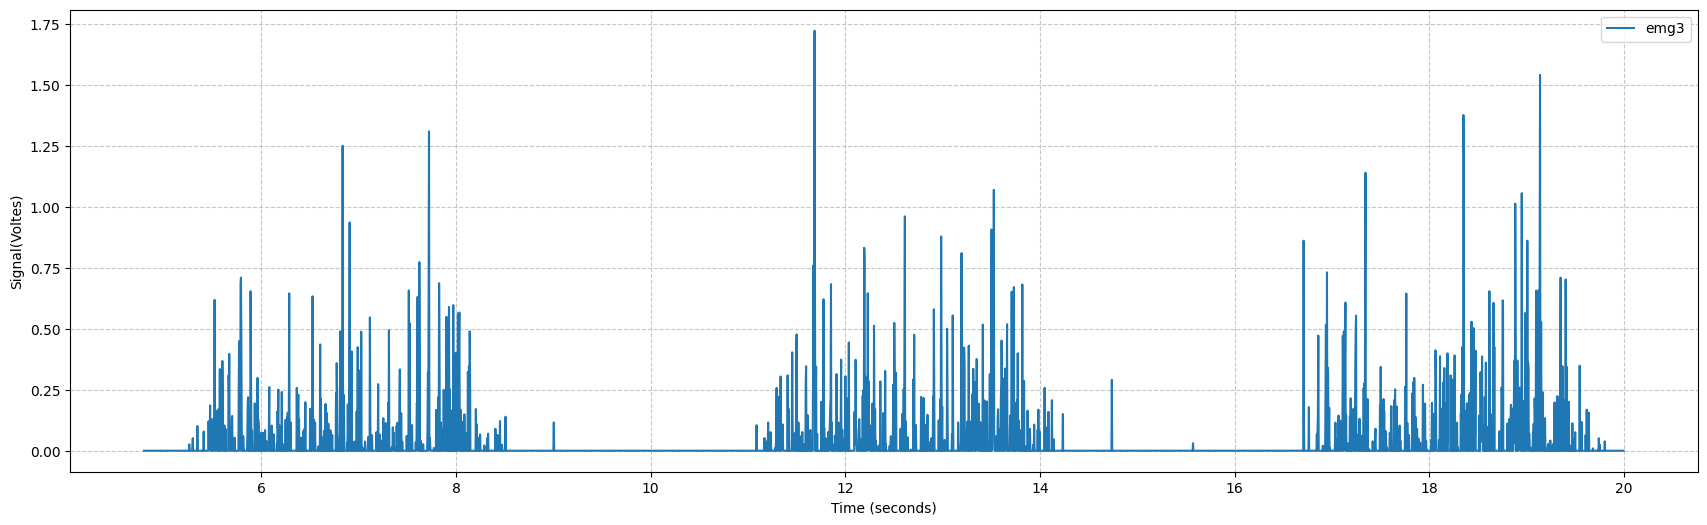

In [5]:
plt.figure(figsize=(21, 6))
plt.plot(time, data_removed_mean[:, 0], label="emg1")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_removed_mean[:, 1], label="emg2")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_removed_mean[:, 2], label="emg3")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

### 1.3 Filter emg signal

Create high and low pass filter settings. A ‘high pass’ filter lets frequencies above that cut-off value pass through, while a ‘low pass’ filter lets frequencies below that cut-off value pass through. Raw surface EMG typically has a frequency content of between 6-500 Hz, with the greatest spectral power between 20-150 Hz. Slow oscillations in the EMG signal are likely due to movement artefacts and fast oscillations are often due to unwanted electrical noise. We can apply a digital filter to let high frequency values above 20 Hz pass through (ie. high pass) and let values below 450 Hz pass through (low pass). The `sp.signal.butter` command requires values between 0 and 1, so filter frequencies are normalised to the Nyquist frequency, which is half of the sampling rate (note: the sampling rate is sometimes called the Nyquist rate, not to be confused with the Nyquist frequency).

EMG signals should always be recorded with analog band-pass filters, often with similar cut-off frequencies (20-450Hz). Between the analog and digital filters, the analog filter is the important one because it acts as an anti-aliasing filter. This means the filter prevents aliasing (distortion) by a higher frequency, non-EMG signal from being recorded. If an EMG signal is aliased and sampled by the analog-to-digital converter, there is no way get rid of this unwanted noise from the signal. Once the EMG signal is analog bandpass filtered and acquired, many researchers choose to not digitally bandpass filter the EMG signal again in Python or Matlab.

Create filter. The scipy butter function is used to design an Nth order Butterworth filter and return the filter coefficients in (B,A) form. So, we specify we want to create a 4th order bandpass filter `([high, low], btype='bandpass')`. The order of a filter refers to how well the filter includes wanted frequencies and excludes unwanted frequencies. 4th order Butterworth filters are quite common; the filter order relates to how well the filter attenuates unwanted frequencies outside the selected cut-off frequency. In this line, we create the filter and store filter coefficients in variables `b` and `a`.

Filter the EMG signal to smooth it. The scipy filtfilt function is used to apply a linear filter to the signal one time forward, one time backwards. Applying a filter to a signal causes a frequency-dependent phase shift. While this phase shift is unavoidable when applying an analog (ie. hardware) filter, the phase shift can be corrected by applying the digital filter backwards. Note that using `filtfilt` means an 8th order filter is being applied with a slightly narrower frequency bandwidth to what was specified in `butter`. In this line, we filter the `data_filtered` signal.

In [6]:
# create bandpass filter for EMG
high = 20/(1000/2)
low = 450/(1000/2)
b, a = butter(4, [high,low], btype='bandpass')
data_filtered = np.vstack([filtfilt(b, a, data_removed_mean[:, 0]), filtfilt(b, a, data_removed_mean[:, 1]), filtfilt(b, a, data_removed_mean[:, 2])]).T

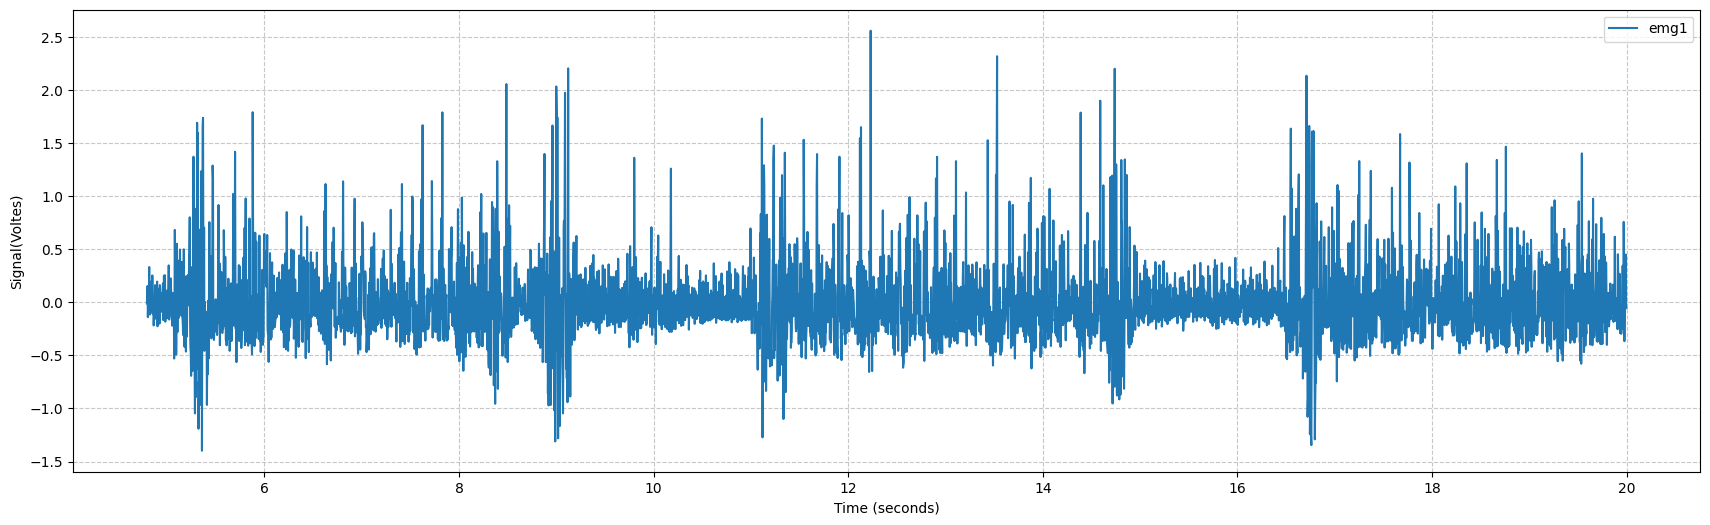

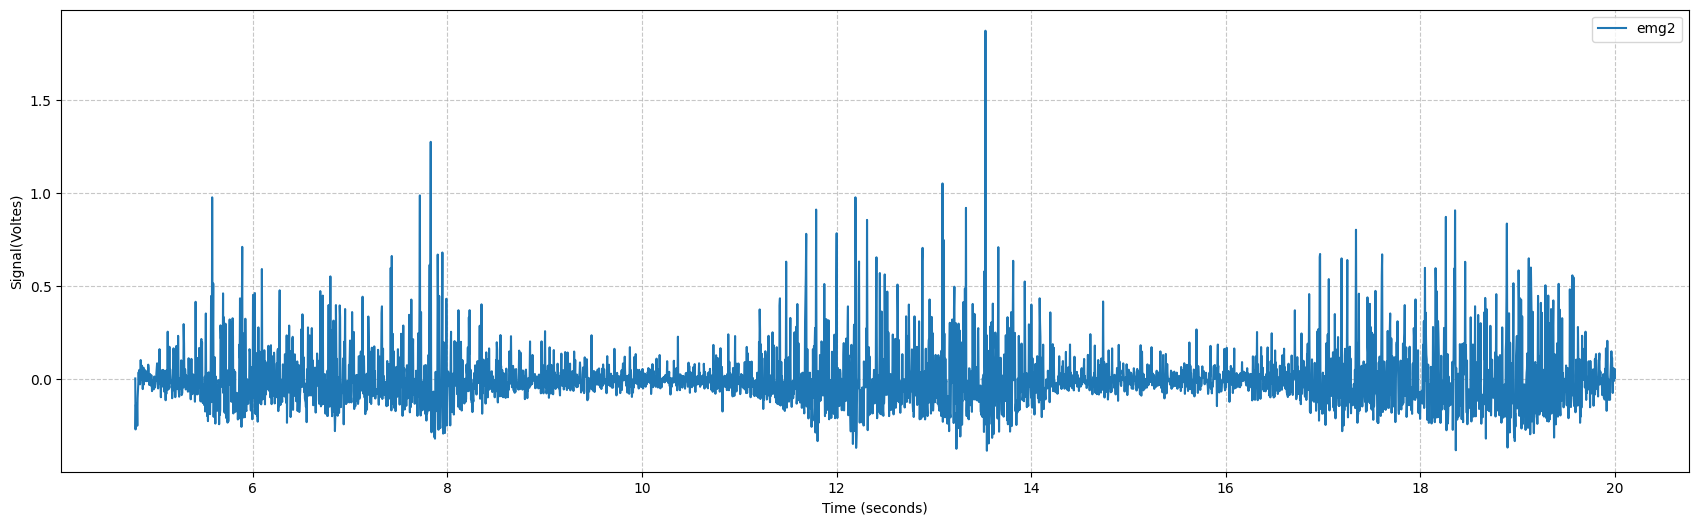

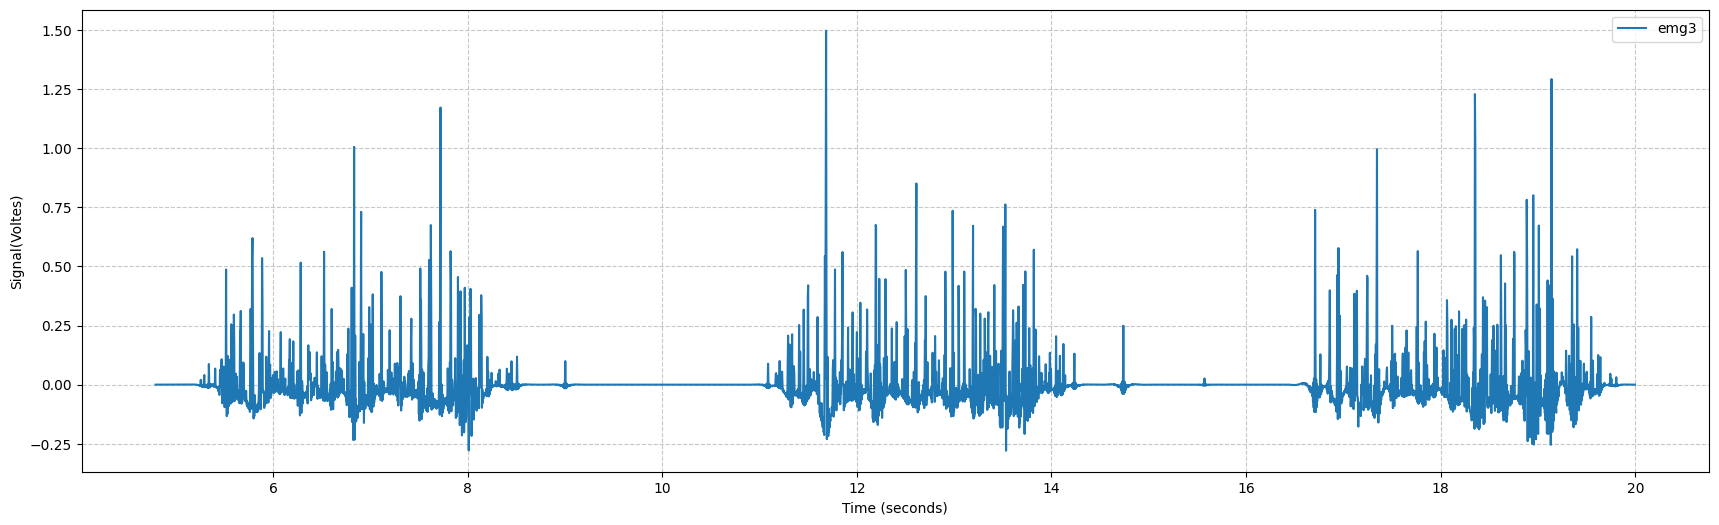

In [7]:
plt.figure(figsize=(21, 6))
plt.plot(time, data_filtered[:, 0], label="emg1")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_filtered[:, 1], label="emg2")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_filtered[:, 2], label="emg3")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

### 1.4 Rectify EMG Signal

Take the absolute of all EMG values (ie. all negative values become positive) so that positive and negative values don’t cancel out when mean EMG is calculated. There is controversy in the EMG analysis field regarding whether EMG signals should be rectified for certain types of analyses (eg. coherence analysis). Another preferred EMG analysis technique is to calculate the root-mean-square (RMS) of the unrectified signal. So, EMG signal rectification may or may not be needed depending on how the signal needs to be analysed.

In [8]:
data_rectified = abs(data_filtered)

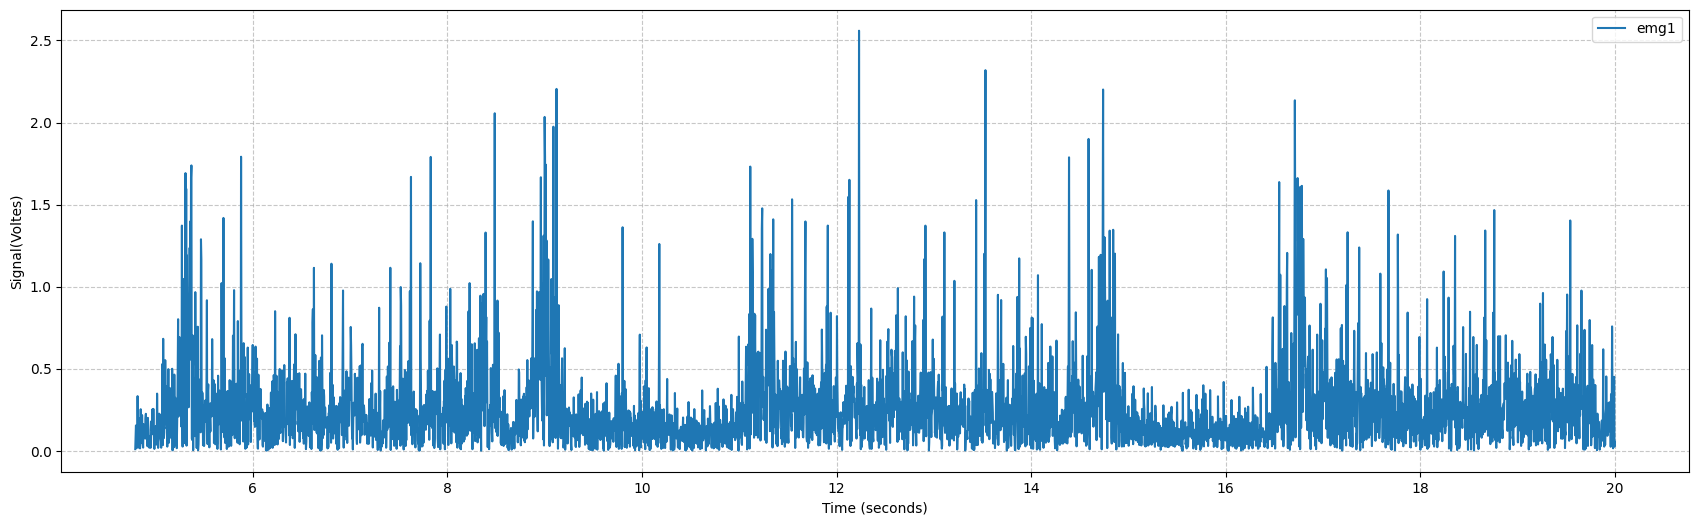

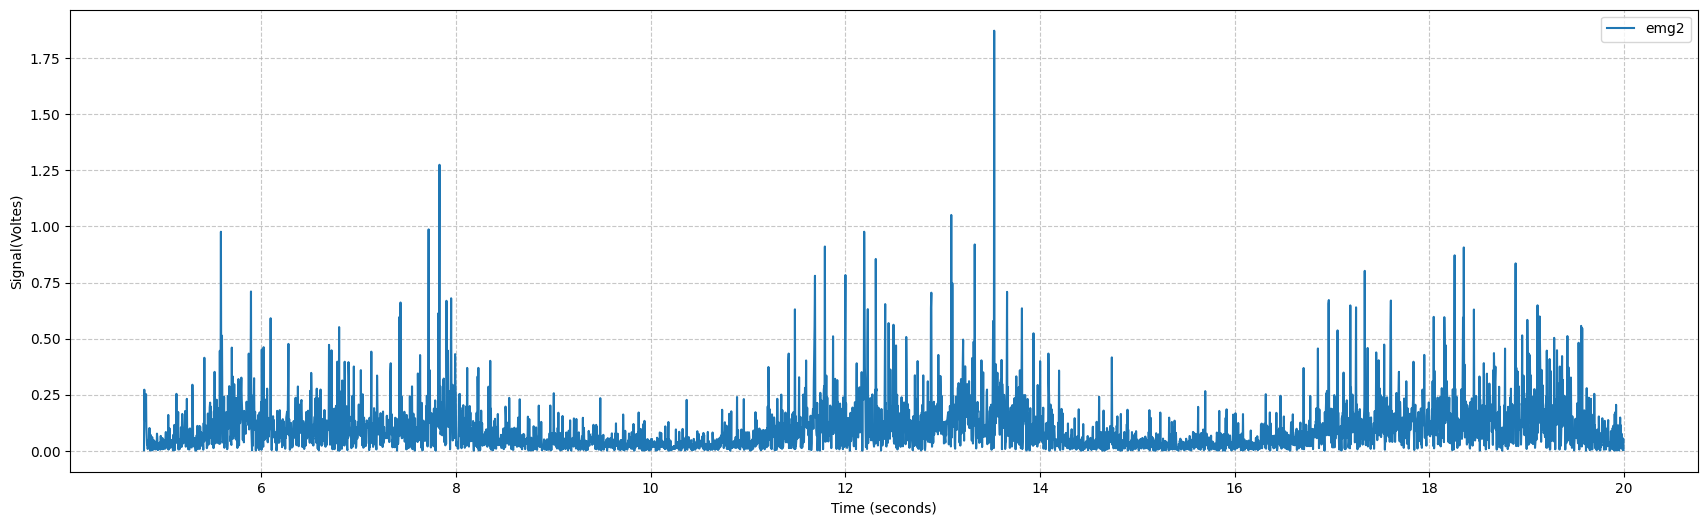

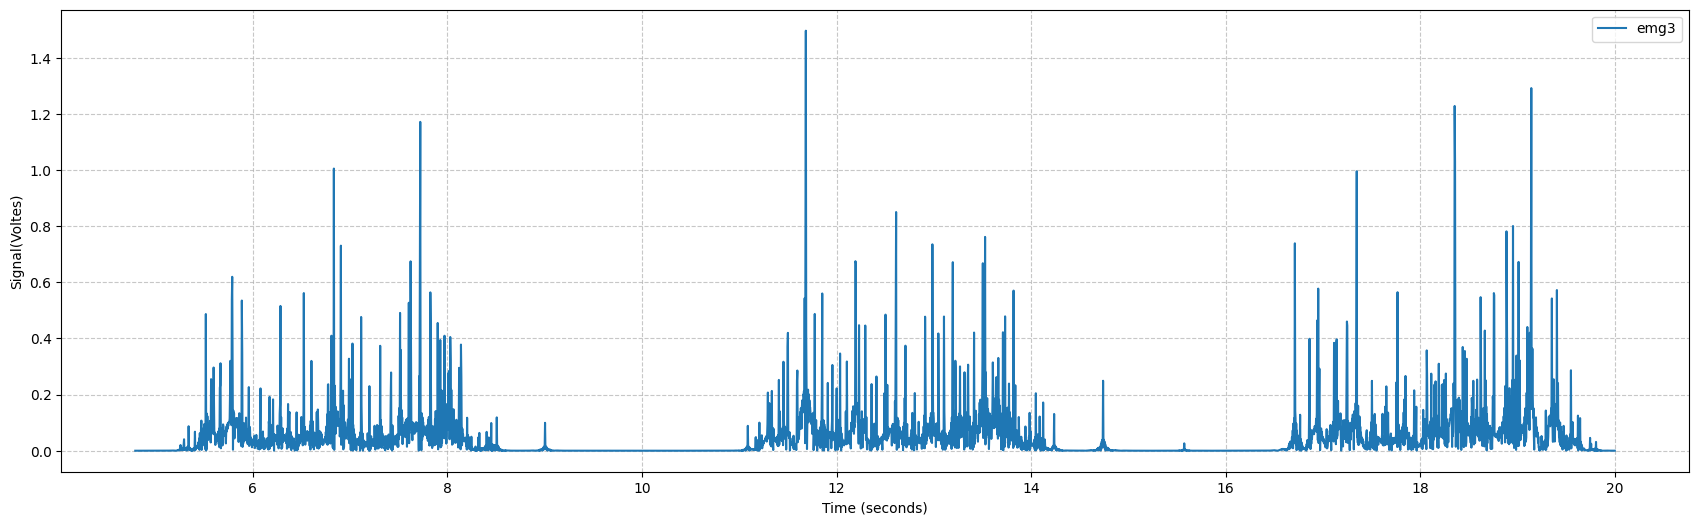

In [9]:
plt.figure(figsize=(21, 6))
plt.plot(time, data_rectified[:, 0], label="emg1")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_rectified[:, 1], label="emg2")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_rectified[:, 2], label="emg3")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

### 1.5 Apply low-pass filter to rectify signal

In [10]:
low_pass = 40/(1000/2)
b2, a2 = butter(4, low_pass, btype='lowpass')
data_envelope = np.vstack([filtfilt(b2, a2, data_rectified[:, 0]), filtfilt(b2, a2, data_rectified[:, 1]), filtfilt(b2, a2, data_rectified[:, 2])]).T

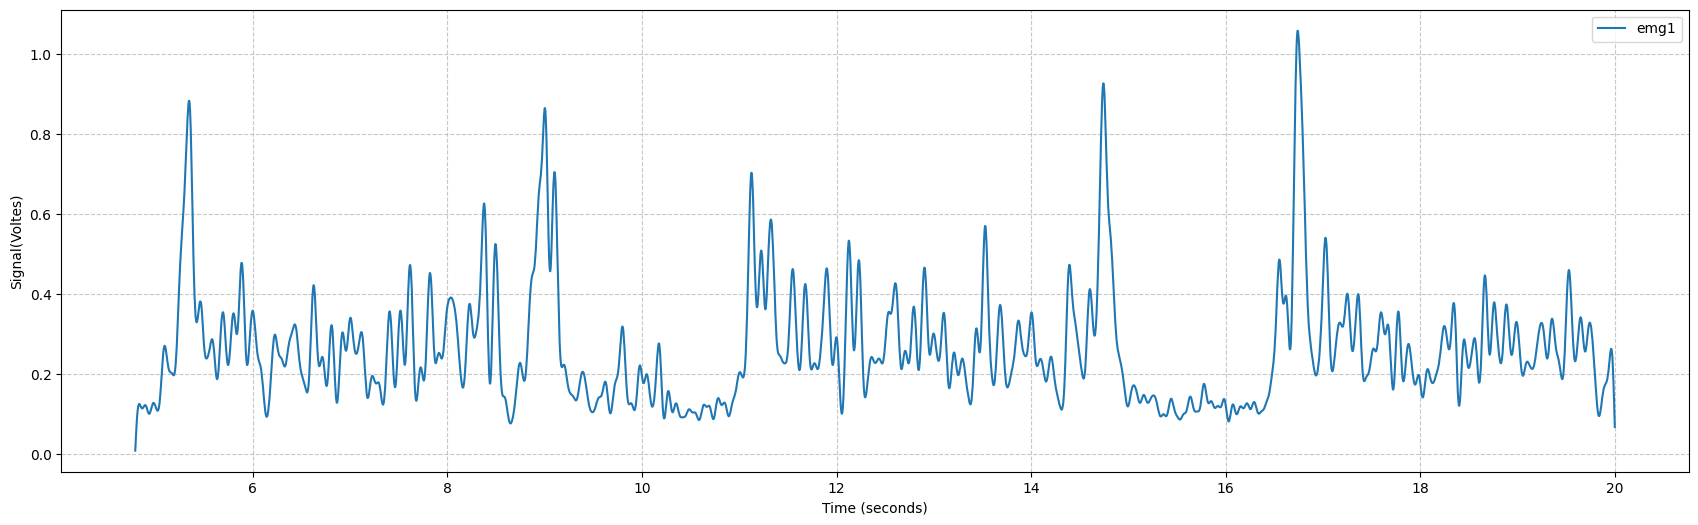

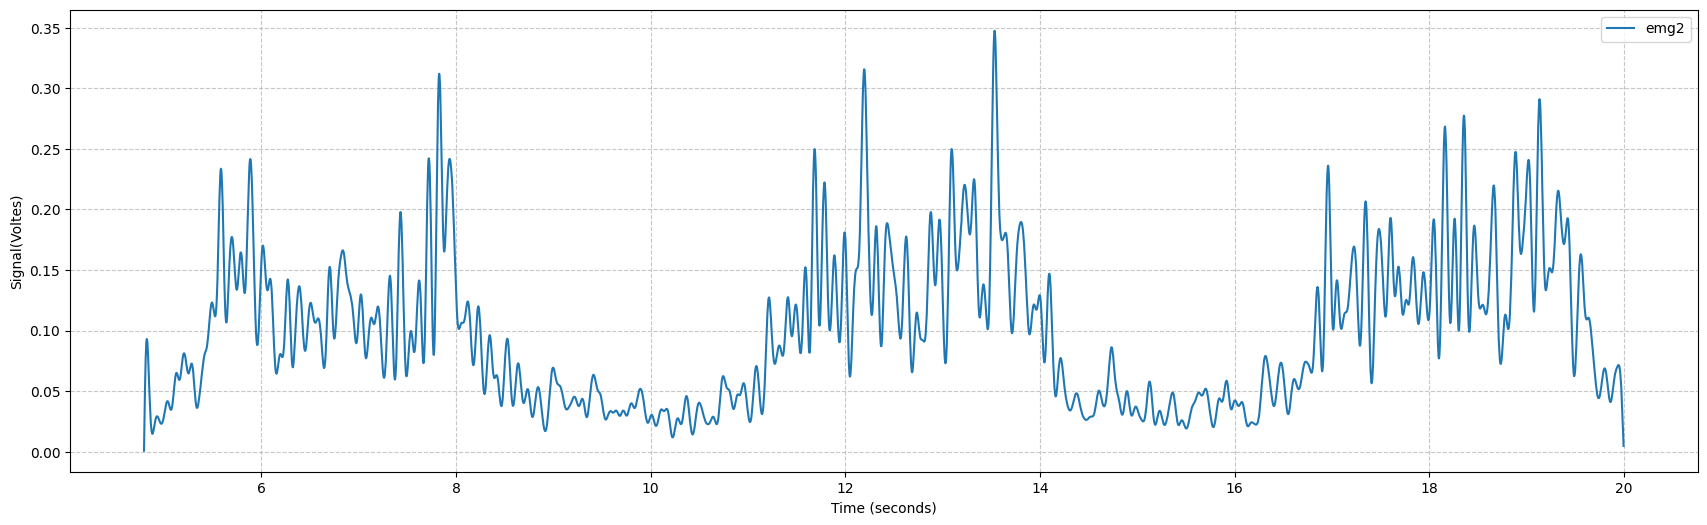

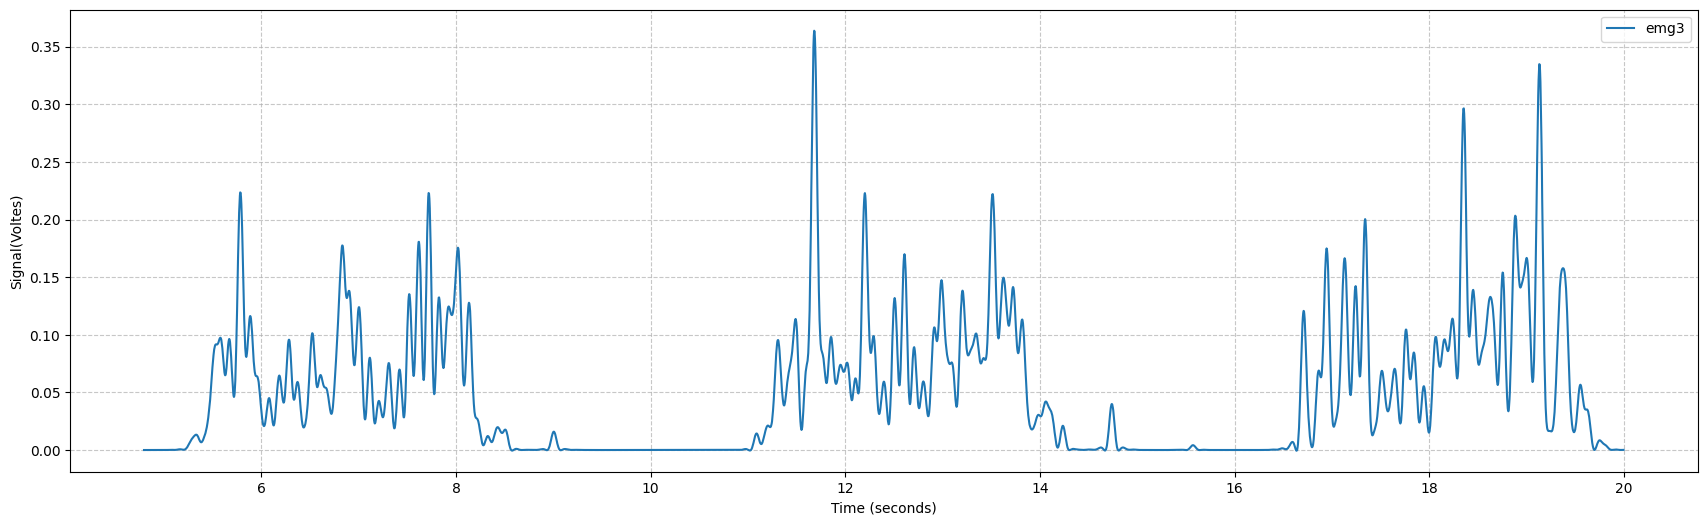

In [11]:
plt.figure(figsize=(21, 6))
plt.plot(time, data_envelope[:, 0], label="emg1")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_envelope[:, 1], label="emg2")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()

plt.figure(figsize=(21, 6))
plt.plot(time, data_envelope[:, 2], label="emg3")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal(Voltes)")
plt.legend()
plt.show()